In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir("../CPSL_TI_Radar")
from CPSL_TI_Radar.ConfigManager import ConfigManager

#specify the configuration path
config_folder_path = "/home/david/Documents/CPSL_TI_Radar/configurations"
#config_file = "DCA1000/custom_configs/ISAR_mocap.cfg"
# config_file = "DCA1000/IWR1843_configs/IWR1843_demo.cfg"
config_file = "nav_configs/1843_test.cfg"
path = os.path.join(config_folder_path,config_file)

#initialize the config manager
config_manager = ConfigManager()
config_manager.load_config_from_cfg(path)
config_manager.compute_radar_perforance()

In [2]:
#number of rx channels
rx_channels = config_manager.radar_performance["angle"]["num_rx_antennas"]

#samples per chirp
samples_per_chirp = int(config_manager.radar_config["profileCfg"]["adcSamples"])

#chirps per frame
chirp_start_profile_idx = int(config_manager.radar_config["frameCfg"]["startIndex"])
chirp_end_profile_idx = int(config_manager.radar_config["frameCfg"]["endIndex"])
chirps_per_loop = chirp_end_profile_idx - chirp_start_profile_idx + 1
chirp_loops_per_frame = int(config_manager.radar_config["frameCfg"]["loops"])
chirps_per_frame = chirp_loops_per_frame * chirps_per_loop

print("rx_channels:{}\nsamples_per_chirp:{}\nchirps per frame:{}\n".format(
    rx_channels,
    samples_per_chirp,
    chirps_per_frame
))

# compute range bins
range_res = config_manager.radar_performance["range"]["range_res"]
range_bins = np.arange(0,samples_per_chirp) * range_res
# compute doppler bins
vel_res = config_manager.radar_performance["velocity"]["vel_res"]
vel_max = config_manager.radar_performance["velocity"]["vel_max"]
num_vel_bins = int(config_manager.radar_performance["velocity"]["num_doppler_bins"])
velocity_bins = np.arange(-1 * vel_max, vel_max, vel_res)

#compute angular bins
num_angular_bins = 64
angle_bins = np.linspace(
    start=0,
    stop=1,
    num=num_angular_bins
)

rx_channels:4
samples_per_chirp:256
chirps per frame:32



In [3]:
#load an adc_data file
adc_file_path = "/home/david/Documents/CPSL_TI_Radar/CPSL_TI_Radar_cpp/build/adc_data.bin"
data = np.fromfile(adc_file_path,dtype=np.int16)
#convert the data into real and complex
data = np.reshape(
    a=data,
    newshape=(2,-1),
    order='F'
)

#obtain the complex numbers
data = data[0] + 1j * data[1]

adc_data_cube = np.reshape(data,
    newshape=(-1,chirps_per_frame,rx_channels,samples_per_chirp),
    order='C'
)

#change to index by [frame,rx_channel,sample,chirp]
adc_data_cube = np.transpose(
    a=adc_data_cube,
    axes=(0,2,3,1)
)
print(adc_data_cube.shape)

(32, 4, 256, 32)


Generate plots from the data:
NOTE: Some plots (range fft and range-doppler) don't make perfect sense at the moment and may need to be fixed.

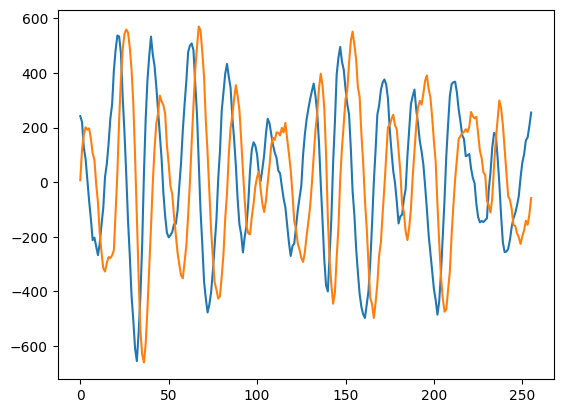

In [4]:
#plot the adc samples

frame = 0
chirp = 0
rx_antenna = 0

samples = adc_data_cube[frame,rx_antenna,:,chirp]

plt.plot(np.real(samples))
plt.plot(np.imag(samples))

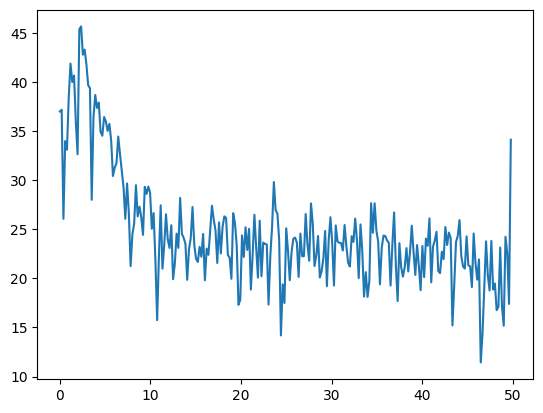

In [5]:
rx_antenna = 0
chirp = 0
samples = adc_data_cube[frame, rx_antenna, :, chirp]

# Apply Hanning window
window = np.hanning(len(samples))
windowed_samples = samples * window

# Perform FFT on windowed samples
data = 10 * np.abs(
    np.log10(
        np.fft.fft(windowed_samples)
    )
)


# data = 20 * np.abs(
#     np.log10(
#         np.fft.fft(windowed_samples)
#     )
# )

plt.plot(range_bins,data)

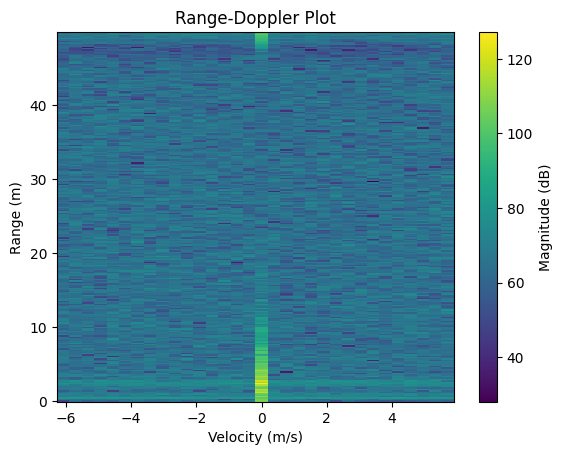

In [6]:
# Plot the range Doppler plot
frame = 0
rx_antenna = 0
samples = adc_data_cube[frame, rx_antenna, :, :]

# Compute range-doppler FFT
data = 20 * np.abs(
    np.log10(
        np.fft.fftshift(
            x=np.fft.fft2(
                samples
            ),
            axes=(1)
        )
    )
)

# Compute the range and doppler bins for the odd columns
vels, rngs = np.meshgrid(velocity_bins, range_bins)

# Plot
plt.pcolormesh(vels, rngs, data)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Range (m)')
plt.title('Range-Doppler Plot')
plt.colorbar(label='Magnitude (dB)')


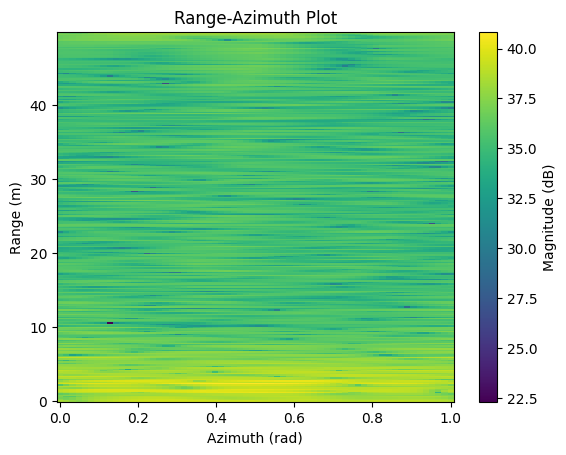

In [7]:
# plot the range azimuth plot
frame=0
chirp = 0
samples = adc_data_cube[frame,:,:,chirp].T

data = 20 * np.abs(
    np.log10(
        np.fft.fftshift(
            x=np.fft.fft2(
                samples,
                s=(samples.shape[0],num_angular_bins)
            ),
            axes=(1)
        )
    )
)

#compute the range and doppler bins
angles,rngs = np.meshgrid(angle_bins,range_bins)

plt.pcolormesh(angles,rngs,20 * np.log10(np.abs(data)))
plt.xlabel('Azimuth (rad)')
plt.ylabel('Range (m)')
plt.title('Range-Azimuth Plot')
plt.colorbar(label='Magnitude (dB)')